In [3]:
import numpy as np
import tifffile as tf
import ntpath
import fnmatch
import os
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
import time
import math
from utils.paq2py import *
from utils.parse_markpoints import ParseMarkpoints
from utils.utils_funcs import *
import seaborn as sns
from random import randint
from scipy import stats
import csv

params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large',}
plt.rcParams.update(params)
sns.set()
sns.set_style('whitegrid')
#%matplotlib notebook

In [239]:
#the path to your paq file
paq_path = r"C:\Users\roble\Documents\Packer lab\Analysis\S1S2\Suite2p\RL035\2019-04-25_RL035_t-007\2019-04-25_RL035_t-007.paq"
#the path to the umbrella suite2p file
s2p_path = r"C:\Users\roble\Documents\Packer lab\Analysis\S1S2\Suite2p\RL035\2019-04-25_RL035_t-007"
#the path to your naparm folder with FOVTarget files
naparm_path = r"C:\Users\roble\Documents\Packer lab\Analysis\S1S2\Suite2p\RL035\2019-04-25_RL035_t-007\2019-04-25_RL035_NAPARM_007"
#the path to your opsin expression file
opsin_path = r"C:\Users\roble\Documents\Packer lab\Analysis\S1S2\Suite2p\RL035\2019-04-25_RL035_t-007\Opsin\2019-04-25_RL035_s-009_Cycle00001_Ch2_000001.ome.tif"

#change this to the name of the paq channel that the stim times was recorded on
stim_name = 'markpoints2packio'

In [240]:
paq = paq_read(paq_path)
raw, stat = s2p_loader(s2p_path, subtract_neuropil=False)

#arr = dfof(raw)
arr = raw
num_units = arr.shape[0]

arr.shape

(223, 7170)

In [241]:
# get baseline fluorescence of each cell to tell if the GCaMP is high resting fluorescence
gcamp_baseline_intensities = []

for i,_ in enumerate(raw):
    gcamp_trace = raw[i]
    fifth_percentile = np.percentile(gcamp_trace, 5)
    gcamp_baseline_intensities.append(fifth_percentile)

np.save(s2p_path + '_gcamp_baseline_intensities.npy', gcamp_baseline_intensities)
# how to tell if it is too high? if it is greater than the average peak intensity of the bottom 50% of cells in the FOV?

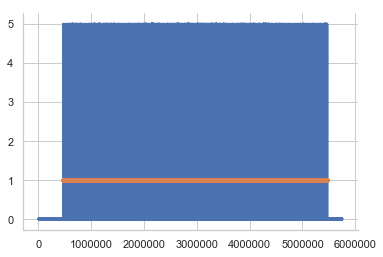

In [213]:
#you might need to run these cells twice to the get the plots for some reason

clock_idx = paq['chan_names'].index('frame_clock')
clock_voltage = paq['data'][clock_idx, :]

frame_clock = threshold_detect(clock_voltage, 1)
plt.figure()
plt.plot(clock_voltage)
plt.plot(frame_clock, np.ones(len(frame_clock)), '.')
sns.despine()
plt.show()

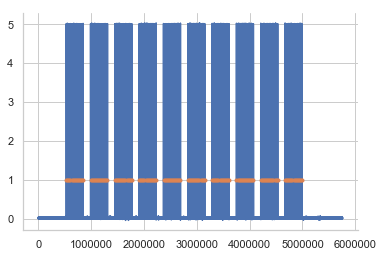

In [214]:
stim_idx = paq['chan_names'].index(stim_name)
stim_volts = paq['data'][stim_idx, :]
stim_times = threshold_detect(stim_volts, 1)

#correct this based on txt file
duration_ms = 250
frame_rate = 30
duration_frames = np.ceil((duration_ms/1000)*frame_rate)
duration_frames = int(duration_frames)

plt.figure()
plt.plot(stim_volts)
plt.plot(stim_times, np.ones(len(stim_times)), '.')
sns.despine()
plt.show()

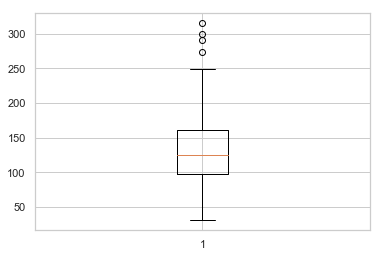

In [215]:
#get mean intensity for each s2p unit from opsin expression image
opsin_image = tf.imread(opsin_path)

opsin_cell_intensities = []

for i,_ in enumerate(stat):
    y_pixels = stat[i]['ypix']
    x_pixels = stat[i]['xpix']
    
    intensity = []
    
    for y_index,x_index in zip(y_pixels, x_pixels):
        intensity.append(opsin_image[y_index][x_index])

    opsin_cell_intensities.append(np.mean(intensity))
    
plt.figure()
plt.boxplot(opsin_cell_intensities);

In [216]:
# work out how many groups in NAPARM from the targets folder + # of 'FOVTargets' files

# lookup recursive for NAPARM target images, find number of stim groups
num_groups = 0
pattern = 'FOVTargets*'
for dirpath, dirnames, filenames in os.walk(naparm_path):

    if not filenames:
        continue

    target_files = fnmatch.filter(filenames, pattern)
    if target_files:
        for i,file in enumerate(target_files):
            num_groups += 1
            print('{}\{}'.format(dirpath, file))
            target_files[i] = os.path.join(dirpath, file)

# separate stim_times in to groups (np.array?)
groups = np.arange(num_groups)
num_stims = len(stim_times)
num_trials = num_stims//num_groups

stim_times_grouped = np.zeros((num_groups, num_trials))

for i in groups:
    stim_times_grouped[i] = stim_times[i:num_stims:num_groups]

# load target images in loop and find pixels with 255 value, note xy indices for each
target_images = tf.imread(target_files)

targets = np.where(target_images == np.amax(target_images)) #indexed as group index, then y index, then x index
group_list = list(targets[0])
num_targets = []

for group in groups:
    num_targets.append(group_list.count(group))

#find roi xy values of cells from stat?
#compare roi xy values of each cell to all target cells and append index to a list of targeted cells if so
target_units = [[] for i in range(num_groups)]
target_indices = [[] for i in range(num_groups)]

for i,_ in enumerate(stat):
    y_pixels = stat[i]['ypix']
    x_pixels = stat[i]['xpix']
    
    for y_index,y_value in enumerate(targets[1]):
        x_value = targets[2][y_index]
        
        y_values = np.arange(y_value-7,y_value+7)
        x_values = np.arange(x_value-7,x_value+7)
        
        #if y_values in y_pixels and x_values in x_pixels:
        if any(y in y_pixels for y in y_values) and any(x in x_pixels for x in x_values): 
            group_index = targets[0][y_index]
            target_units[group_index].append(stat[i]['original_index'])
            target_indices[group_index].append(i)

C:\Users\roble\Documents\Packer lab\Analysis\S1S2\Suite2p\RL036\2019-04-25_RL036_t-009\2019-04-25_RL036_NAPARM_009\Targets\FOVTargets_001_2019-04-25_RL036_NAPARM_009.tif
C:\Users\roble\Documents\Packer lab\Analysis\S1S2\Suite2p\RL036\2019-04-25_RL036_t-009\2019-04-25_RL036_NAPARM_009\Targets\FOVTargets_002_2019-04-25_RL036_NAPARM_009.tif
C:\Users\roble\Documents\Packer lab\Analysis\S1S2\Suite2p\RL036\2019-04-25_RL036_t-009\2019-04-25_RL036_NAPARM_009\Targets\FOVTargets_003_2019-04-25_RL036_NAPARM_009.tif
C:\Users\roble\Documents\Packer lab\Analysis\S1S2\Suite2p\RL036\2019-04-25_RL036_t-009\2019-04-25_RL036_NAPARM_009\Targets\FOVTargets_004_2019-04-25_RL036_NAPARM_009.tif
C:\Users\roble\Documents\Packer lab\Analysis\S1S2\Suite2p\RL036\2019-04-25_RL036_t-009\2019-04-25_RL036_NAPARM_009\Targets\FOVTargets_005_2019-04-25_RL036_NAPARM_009.tif
C:\Users\roble\Documents\Packer lab\Analysis\S1S2\Suite2p\RL036\2019-04-25_RL036_t-009\2019-04-25_RL036_NAPARM_009\Targets\FOVTargets_006_2019-04-25_R

In [217]:
stim_start_frames = []

for stim in stim_times:

    #the index of the frame immediately preceeding stim
    stim_start_frame = next(i-1 for i,sample in enumerate(frame_clock) if sample - stim >= 0)
    stim_start_frames.append(stim_start_frame)
    
stim_start_frames = np.array(stim_start_frames)

#sanity check
assert max(stim_start_frames) < arr.shape[1]

stim_frames_grouped = np.empty((num_groups, num_trials))

for i in groups:
    stim_frames_grouped[i] = stim_start_frames[i:num_stims:num_groups]

In [218]:
#pick a group to analyse (indexing starts at 0)
#group_i = 0

#this is the key parameter for the sta, how many frames before and after the stim do you want to use
pre_frames = 30
post_frames = 30

#list of cell pixel intensity values during each stim on each trial
all_trials_grouped = []

# the average of every trial
stas_grouped = []

sta_amplitudes_grouped = []

t_tests_grouped = []
mann_whits_grouped = []

for group_i in groups:
    
    #list of cell pixel intensity values during each stim on each trial
    all_trials = []

    # the average of every trial
    stas = []

    sta_amplitudes = []
    
    t_tests = []
    mann_whits = []

    #loop through each cell
    for i, unit in enumerate(arr):

        trials = []
        df = []
        amplitudes = []

        # a flat list of all observations before stim occured
        pre_obs = []
        # a flat list of all observations after stim occured
        post_obs = []

        for stim in stim_frames_grouped[group_i]:
            stim = int(stim)
            
            # get baseline values from pre_stim
            pre_stim  = unit[stim-pre_frames : stim]
            baseline = np.mean(pre_stim)
            
            # the whole trial and dfof using baseline
            trial = unit[stim-pre_frames : stim+post_frames]
            trial = [((f-baseline)/ baseline) * 100 for f in trial]
            trials.append(trial)
            
            pre_stim  = trial[ : pre_frames-1]
            post_stim = trial[pre_frames : ]

            # append to flat lists
            [pre_obs.append(ob) for ob in pre_stim]
            [post_obs.append(ob) for ob in post_stim]

            #calc amplitude of response        
            pre_f = trial[pre_frames-10 : pre_frames]
            pre_f = np.mean(pre_f)
            post_stim_frame = pre_frames + duration_frames
            post_f = trial[post_stim_frame : post_stim_frame+10]
            post_f = np.mean(post_stim)
            amplitude = post_f - pre_f
            amplitudes.append(amplitude)

        all_trials.append(trials)

        #average amplitudes across trials
        all_amplitudes = np.array(amplitudes)
        sta_amplitude = np.mean(all_amplitudes,0)
        sta_amplitudes.append(sta_amplitude)

        #average across all trials
        sta = np.mean(trials, 0)        
        stas.append(sta)

        #remove nans from flat lists
        pre_obs = [x for x in pre_obs if ~np.isnan(x)]
        post_obs = [x for x in post_obs if ~np.isnan(x)]

        #t_test and man whit test pre and post stim (any other test could also be used here)
        t_test = stats.ttest_ind(pre_obs, post_obs)
        t_tests.append(t_test)

        mann_whit = stats.mannwhitneyu(pre_obs, post_obs)
        mann_whits.append(mann_whit)
    
    # the average of every trial
    stas_grouped.append(stas)
    
    # list of cell pixel intensity values during each stim on each trial
    all_trials_grouped.append(all_trials)   
    
    t_tests_grouped.append(t_tests)
    mann_whits_grouped.append(mann_whits)

    sta_amplitudes_grouped.append(sta_amplitudes)

stas_grouped = np.array(stas_grouped)
all_trials_grouped = np.array(all_trials_grouped)
sta_amplitudes_grouped = np.array(sta_amplitudes_grouped)
t_tests_grouped = np.array(t_tests_grouped)
mann_whits_grouped = np.array(mann_whits_grouped)

C:\Users\roble\Anaconda3\lib\site-packages\ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in float_scalars


In [219]:
all_trials_grouped.shape # output is: number of stim groups, total number of cells, number of trials, sta length (frames)

(17, 315, 10, 60)

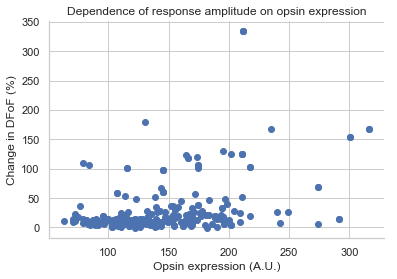

In [220]:
x_axis = []
y_axis = []

for group_i in groups:
    target_i = np.array(target_indices[group_i])

    for i in target_i:
        x_axis.append(opsin_cell_intensities[i])
        y_axis.append(sta_amplitudes_grouped[group_i,i])

plt.figure()
plt.scatter(x_axis, y_axis)
plt.title('Dependence of response amplitude on opsin expression')
plt.xlabel('Opsin expression (A.U.)')
plt.ylabel('Change in DFoF (%)')
sns.despine()
plt.show()

np.save(s2p_path + '_opsin_int.npy', x_axis)
np.save(s2p_path + '_sta_amp.npy', y_axis)

In [221]:
#set this to true if you want to multiple comparisons correct for the number of cells
multi_comp_correction = True
if not multi_comp_correction: 
    divisor = 1
else:
    divisor = num_units

In [222]:
#choose group to analyse + plot
group_i = 1

p_vals = [t[1] for t in t_tests_grouped[group_i]]
idx = range(len(p_vals))

if multi_comp_correction:
    print('performing t-test on cells with mutliple comparisons correction')
else:
    print('performing t-test on cells without mutliple comparisons correction')
    
count = 0
sig_units = []
for p,i in sorted(zip(p_vals,idx)):
    if p < 0.05 / divisor:
        count += 1
        unit_index = stat[i]['original_index']
        if unit_index in target_units[group_i]: target_boolean = 'yes' 
        else: target_boolean = 'no' 
        print('Stim {} significantly changed fluoresence of s2p unit {}, its P value is {}. Target? {}'.format(group_i,unit_index, p, target_boolean))
        sig_units.append(i) #significant units

performing t-test on cells with mutliple comparisons correction
Stim 1 significantly changed fluoresence of s2p unit 99, its P value is 2.3062093691824958e-45. Target? yes
Stim 1 significantly changed fluoresence of s2p unit 79, its P value is 4.869546509540745e-44. Target? yes
Stim 1 significantly changed fluoresence of s2p unit 170, its P value is 1.139460750855033e-19. Target? yes
Stim 1 significantly changed fluoresence of s2p unit 266, its P value is 1.437836848160439e-17. Target? yes
Stim 1 significantly changed fluoresence of s2p unit 261, its P value is 8.32610236762055e-17. Target? no
Stim 1 significantly changed fluoresence of s2p unit 237, its P value is 2.6712538542491924e-16. Target? no
Stim 1 significantly changed fluoresence of s2p unit 187, its P value is 8.50895656489791e-09. Target? no
Stim 1 significantly changed fluoresence of s2p unit 60, its P value is 1.512110650335866e-08. Target? no
Stim 1 significantly changed fluoresence of s2p unit 14, its P value is 1.70924

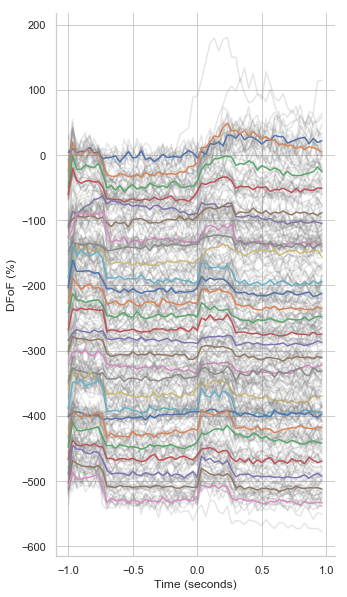

In [223]:
plt.figure(figsize=(5,10))

for i,unit in enumerate(sig_units):
    line_offset = i*20
    
    unit_index = stat[i]['original_index']
    
    if unit_index in target_units[group_i]: 
        target_report = 'target' 
    else:
        target_report = ''
    
    frame_rate = 30
    x_axis = (np.arange(len(sta)) - pre_frames) / frame_rate

    sta = stas_grouped[group_i][unit]
    [plt.plot(x_axis, t - line_offset, c='grey', alpha=0.2) for t in all_trials_grouped[group_i,unit,:,:]]
    plt.plot(x_axis, sta - line_offset)
    
# plt.title('Unit ' + str(unit_index) + ' ' + target_report)
plt.xlabel('Time (seconds)')
plt.ylabel('DFoF (%)')
#plt.ylim((-100,200))
sns.despine()
#plt.savefig('s2_responsive_cell.pdf')

C:\Users\roble\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\roble\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in less


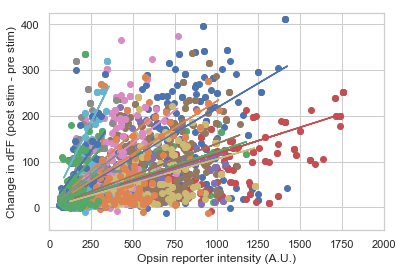

In [134]:
# plot opsin vs. sta amplitudes for each FOV
all_opsin = []
all_amplitudes = []

for dirpath, dirnames, filenames in os.walk(path):
    
    for file in filenames:
        if 'sta_amp' in file:
            amplitudes = np.load(os.path.join(path, file))
            all_amplitudes.append(amplitudes)
        if 'opsin' in file:
            opsin = np.load(os.path.join(path, file))
            all_opsin.append(opsin)

# plot every FOV colour-coded on same plot
fig = plt.figure()
ax1 = fig.add_subplot(111)

for i,_ in enumerate(all_opsin):
#     plt.figure() # plot each FOV separately
    keep_idx = np.where((all_amplitudes[i] > -2000) & (all_amplitudes[i] < 2000)) # filter out extreme values over 2000 dff change#
    all_amplitudes[i] = all_amplitudes[i][keep_idx]
    all_opsin[i] = all_opsin[i][keep_idx]
    
    plt.scatter(all_opsin[i], all_amplitudes[i])
    slope, intercept, r_value, p_value, std_err = stats.linregress(all_opsin[i], all_amplitudes[i])
#     print ("r-squared:", r_value**2)
#     print ("p-value:", p_value)
#     print("slope:", slope)
    y = slope*all_opsin[i]
    plt.plot(all_opsin[i], y)
    plt.axis([0, 2000, -50, 425])
    plt.xlabel('Opsin reporter intensity (A.U.)')
    plt.ylabel('Change in dFF (post stim - pre stim)')
#     plt.savefig(r'C:\Users\roble\Documents\Packer lab\Lab meetings\2019-05-08_show_and_tell\2019-05-07_opsin_vs_staAmplitudes_' + str(i) + '.svg')

all_opsin = [y for x in all_opsin for y in x]
all_amplitudes = [y for x in all_amplitudes for y in x]

r-squared: 0.2315370596587756
p-value: 2.3833124490538884e-171
slope: 0.11831836005366363


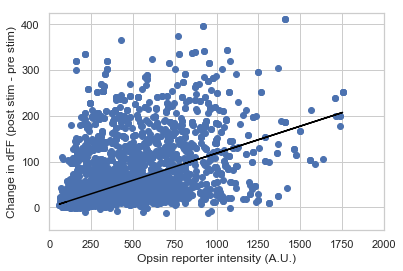

In [77]:
plt.figure()
plt.scatter(all_opsin, all_amplitudes)
slope, intercept, r_value, p_value, std_err = stats.linregress(all_opsin, all_amplitudes)
print ("r-squared:", r_value**2)
print ("p-value:", p_value)
print("slope:", slope)
y = slope*np.array(all_opsin)
plt.plot(all_opsin, y, 'black')
plt.axis([0, 2000, -50, 425])
plt.xlabel('Opsin reporter intensity (A.U.)')
plt.ylabel('Change in dFF (post stim - pre stim)')
plt.show()
# plt.savefig(r'C:\Users\roble\Documents\Packer lab\Lab meetings\2019-05-08_show_and_tell\2019-05-07_opsin_vs_staAmplitudes_grouped.svg')

Text(0, 0.5, 'Change in dFF (post stim - pre stim)')

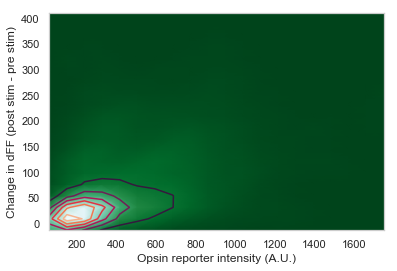

In [127]:
# Evaluate a gaussian kde on a regular grid of nbins x nbins over data extents
x = np.array(all_opsin)
y = np.array(all_amplitudes)
data = np.column_stack((x,y))
nbins = 20

k = stats.gaussian_kde(data.T)
xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))

# contour
plt.figure()
# plt.set_title('Contour')
plt.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='gouraud', cmap=plt.cm.BuGn_r)
plt.contour(xi, yi, zi.reshape(xi.shape) )
plt.xlabel('Opsin reporter intensity (A.U.)')
plt.ylabel('Change in dFF (post stim - pre stim)')

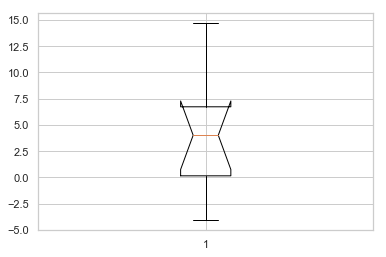

In [242]:
plt.figure()
plt.boxplot(all_amplitudes, notch=True);

In [245]:
# plot opsin vs. sta amplitudes for each FOV
all_opsin = []
all_amplitudes = []
all_baselines = []

path = r'C:\Users\roble\Documents\Packer lab\Analysis\S1S2\Suite2p\Outputs'

for dirpath, dirnames, filenames in os.walk(path):
    
    for file in filenames:
        if 'sta_amp' in file:
            amplitudes = np.load(os.path.join(dirpath, file))
            all_amplitudes.append(amplitudes)
        if 'opsin' in file:
            opsin = np.load(os.path.join(dirpath, file))
            all_opsin.append(opsin)
        if 'gcamp' in file:
            gcamp = np.load(os.path.join(dirpath, file))
            all_baselines.append(gcamp)
            

all_opsin = [y for x in all_opsin for y in x]
all_amplitudes = [y for x in all_amplitudes for y in x]
all_baselines = [y for x in all_baselines for y in x]

all_baselines = np.array(all_baselines)

high_baseline = np.where((all_baselines > 200)) # filter out extreme values over 200 baseline
x = all_amplitudes[high_baseline]
y = all_opsin[high_baseline]
plt.figure()
plt.scatter(all_opsin, all_amplitudes)

x = all_amplitudes[~high_baseline]
y = all_amplitudes[~high_baseline]
plt.figure()
plt.scatter(all_opsin, all_amplitudes)

TypeError: list indices must be integers or slices, not tuple